In [195]:
using JLD2
using DataFrames
using MLUtils
using Flux
using MLUtils
using Statistics
using Random
using PythonPlot
using ProgressMeter
using Distributions


In [20]:
# define all the parameter values

# Epsilon values 
eps_vals = collect(1:-.02:.01) # 17
N_eps = length(eps_vals)

# Quanta values
q_vals = collect(2:4:100) #
N_q = length(q_vals)

# NT vals
NT_vals = [25,50,100,200,400, 800]
N_NT = length(NT_vals)

N_Object_Vals = [2, 3, 4, 5, 6, 8, 10];
N_N_Object_vals = length(N_Object_Vals)

# Mem Slope Vals
# memory slopes (this won't be looped over)
mem_slopes = [.025, .05, .1, .2, .4, .8, 1.6]
N_ms = length(mem_slopes)

# Other values are time before cue and time after cue
N_Seconds_Pre_Vals = .25 * 2 .^ (0:5)
N_N_Seconds_Pre_Vals = length(N_Seconds_Pre_Vals)

N_Seconds_Post_Vals = .25 * 2 .^ (0:5)
N_N_Seconds_Post_Vals = length(N_Seconds_Post_Vals)


# For trials with no retro-cue - start from .25 seconds and multiply by 1.5 8 times
N_Seconds_NoCue = .25 * 2 .^ (0:6)
N_N_Seconds_NoCue = length(N_Seconds_NoCue)


# make a bit list of parameters

# Create all parameter combinations
function create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
    all_params = []
    
    for epsilon in eps_vals
        for N_Quanta in q_vals
            for NT_per_Second in NT_vals
                for mem_slope in mem_slopes
                    push!(all_params, Dict(
                        "epsilon" => epsilon,
                        "N_Quanta" => Int(N_Quanta),
                        "NT_per_Second" => Int(NT_per_Second),
                        "mem_slope" => mem_slope
                    ))
                end
            end
        end
    end
    
    return all_params
end

all_params = create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes);
all_params[1:5]

5-element Vector{Any}:
 Dict{String, Real}("NT_per_Second" => 25, "N_Quanta" => 2, "epsilon" => 1.0, "mem_slope" => 0.025)
 Dict{String, Real}("NT_per_Second" => 25, "N_Quanta" => 2, "epsilon" => 1.0, "mem_slope" => 0.05)
 Dict{String, Real}("NT_per_Second" => 25, "N_Quanta" => 2, "epsilon" => 1.0, "mem_slope" => 0.1)
 Dict{String, Real}("NT_per_Second" => 25, "N_Quanta" => 2, "epsilon" => 1.0, "mem_slope" => 0.2)
 Dict{String, Real}("NT_per_Second" => 25, "N_Quanta" => 2, "epsilon" => 1.0, "mem_slope" => 0.4)

Functions to load results turn into features, turn back into original format, and to plot

In [59]:
function load_results(N_Quanta, epsilon, NT_per_Second; res_part = "delayed_memory")

    # res_part should either be "delayed_memory" or "retrocue"

    res_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Data/Memory_Models/manyloadsim_run1"
    
    file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_$(NT_per_Second).jld2"

    full_file_path = joinpath(res_folder, res_part, file_name)

    results = load(full_file_path)
    
    return results

end

# function to load delay_prob_correct and retro_cue_prob_correct
function load_prob_correct(N_Quanta, epsilon, NT_per_Second)

    # load delayed memory results
    these_res = load_results(N_Quanta, epsilon, NT_per_Second, res_part = "delayed_memory")

    # N_Obj X N_Sec, N_Memslopes - delay_prob_correct
    delay_prob_correct = these_res["delay_prob_correct"]

    # load retro cue results
    these_res = load_results(N_Quanta, epsilon, NT_per_Second, res_part = "retrocue")

    # N_Obj, N_Sec_Pre, N_Sec_Post, N_Memslopes - retro_cue_prob_correct
    retro_cue_prob_correct = these_res["retro_cue_prob_correct"]

    return delay_prob_correct, retro_cue_prob_correct

end

# Function to load a single data point and turn it into a feature and target vector
function load_data_point(params)
    delay_prob, retro_prob = load_prob_correct(
        params["N_Quanta"],
        params["epsilon"],
        params["NT_per_Second"]
    )

    mem_slopes = [.025, .05, .1, .2, .4, .8, 1.6]
    mem_slope_idx = findfirst(x -> isapprox(x, params["mem_slope"], rtol=1e-10), mem_slopes)
    
    if isnothing(mem_slope_idx)
        error("Invalid mem_slope value: $(params["mem_slope"])")
    end
    
    # Extract and flatten features
    delay_features = vec(delay_prob[:, :, mem_slope_idx])
    retro_features = vec(retro_prob[:, :, :, mem_slope_idx])
    
    # Concatenate features
    features = Float32.(vcat(delay_features, retro_features))
    
    # Target values
    targets = Float32[
        params["N_Quanta"] / 100,
        params["epsilon"],
        params["NT_per_Second"] / 800,
        params["mem_slope"]
    ]
    
    return features, targets
end

function plot_memory(delay_vals, retro_vals, N_Object_Vals, N_Seconds_NoCue, N_Seconds_Pre_Vals, N_Seconds_Post_Vals)
    N_N_Object_vals = length(N_Object_Vals)
    N_N_Seconds_NoCue = length(N_Seconds_NoCue)
    N_N_Seconds_Pre_Vals = length(N_Seconds_Pre_Vals)
    N_N_Seconds_Post_Vals = length(N_Seconds_Post_Vals)

    fig, ax = subplots(1, N_N_Object_vals, figsize=(8, 3), dpi=200, constrained_layout=true, sharex = true, sharey = true)
    for N_Obj_idx = 1:N_N_Object_vals
        ax[N_Obj_idx-1].plot(N_Seconds_NoCue, delay_vals[N_Obj_idx, :], "--o", color = "gray", ms = 3)

        for N_Sec_Pre_idx = 1:length(N_Seconds_Pre_Vals)
            N_Seconds_Pre = N_Seconds_Pre_Vals[N_Sec_Pre_idx]
            ax[N_Obj_idx-1].plot(N_Seconds_Pre .+ N_Seconds_Post_Vals, retro_vals[N_Obj_idx, N_Sec_Pre_idx, :], "--o", ms = 3, color = "gray", label = "$(round(N_Seconds_Pre, digits = 2))")
        end

        ax[N_Obj_idx-1].set_title("N Objects: $(N_Object_Vals[N_Obj_idx])")
        ax[N_Obj_idx-1].set_xlabel("Time (s)")
        ax[N_Obj_idx-1].set_ylabel("Prob. Correct")

    end
end


# build function to turn features back into delay_prob_correct and retro_cue_prob_correct at a single mem_slope_val
function features_to_prob_correct(features, N_Object_Vals, N_Seconds_NoCue, N_Seconds_Pre_Vals, N_Seconds_Post_Vals)
    N_N_Object_vals = length(N_Object_Vals)
    N_N_Seconds_NoCue = length(N_Seconds_NoCue)
    N_N_Seconds_Pre_Vals = length(N_Seconds_Pre_Vals)
    N_N_Seconds_Post_Vals = length(N_Seconds_Post_Vals)

    N_delay_prob_values = N_N_Object_vals * N_N_Seconds_NoCue
    delay_features_vals = features[1:N_delay_prob_values]
    delay_prob_correct = reshape(delay_features_vals, N_N_Object_vals, N_N_Seconds_NoCue)

    N_retro_prob_values = N_N_Object_vals * N_N_Seconds_Pre_Vals * N_N_Seconds_Post_Vals
    retro_features_vals = features[N_delay_prob_values+1:end]
    retro_cue_prob_correct = reshape(retro_features_vals, N_N_Object_vals, N_N_Seconds_Pre_Vals, N_N_Seconds_Post_Vals)

    return delay_prob_correct, retro_cue_prob_correct
end



features_to_prob_correct (generic function with 1 method)

In [198]:


function collect_all_features_to_matrix(params_list, y_idxs = 1:2) # adjust y_idxs later
    all_features = Vector{Vector{Float32}}()
    all_targets = Vector{Vector{Float32}}()
    
    for params in params_list
        features, targets = load_data_point(params)
        push!(all_features, features)
        push!(all_targets, targets)
    end
    
    # X is n_features X n_samples
    X = reduce(hcat, all_features)

    # Y is n_targets X n_samples
    Y = reduce(hcat, all_targets)
    Y = Y[y_idxs, :];

    return X, Y
end



# Create a data loading function that returns an iterator
function create_data_iterator(X,Y, batch_size)

    # X, Y = collect_all_features_to_matrix(params_list)
    
    # Create DataLoader with matrices
    return DataLoader((X, Y); 
                     batchsize=batch_size, 
                     shuffle=true)
end

function generate_binomial_samples(X_test, N_flips)
    # Get dimensions of X_test
    rows, cols = size(X_test)
    
    # Create output matrix
    samples = zeros(Int, rows, cols)
    
    # Generate binomial samples for each element
    for i in 1:rows
        for j in 1:cols
            p = X_test[i,j]
            samples[i,j] = rand(Binomial(N_flips, p))
        end
    end
    
    return samples ./ N_flips
end




generate_binomial_samples (generic function with 1 method)

In [164]:
# try doing this for just a single mem_slpoe nad NT_Val

this_mem_slope = mem_slopes[4]
this_NT_val = NT_vals[6]

params_list = create_parameter_list(eps_vals, q_vals, [this_NT_val], [this_mem_slope]);

(X, Y) = collect_all_features_to_matrix(params_list)
Xs, Ys = shuffleobs((X, Y))
(X_train, Y_train), (X_test, Y_test) = splitobs((Xs, Ys); at=0.7)
data_loader = create_data_iterator(X_train, Y_train, 32)

#example_X, example_Y = first(data_loader)

# print("Mem Slope: $(this_mem_slope), NT: $(this_NT_val)")

28-element DataLoader(::Tuple{SubArray{Float32, 2, Matrix{Float32}, Tuple{Base.Slice{Base.OneTo{Int64}}, Vector{Int64}}, false}, SubArray{Float32, 2, Matrix{Float32}, Tuple{Base.Slice{Base.OneTo{Int64}}, Vector{Int64}}, false}}, shuffle=true, batchsize=32)
  with first element:
  (301×32 Matrix{Float32}, 2×32 Matrix{Float32},)

In [189]:
# build a simple neural network

hidden_size = 8
learning_rate = 0.001
n_epochs = 500

# use flux cross entropy loss fucntion

loss_fun = Flux.mse;

example_X, example_Y = first(data_loader)

model = Chain(
    Dense(size(example_X, 1), hidden_size, relu),
    Dense(hidden_size, size(example_Y, 1))
)

optim = Flux.setup(Flux.Adam(learning_rate), model)  # will store optimiser momentum, etc.
optim_start = deepcopy(optim)

# Train the model
test_losses = []
@showprogress for epoch in 1:n_epochs
    for (x, y) in data_loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            loss_fun(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        #push!(losses, loss)  # logging, outside gradient context
    end
    test_loss = loss_fun(model(X_test), Y_test)
    push!(test_losses, test_loss)
end

optim_end = deepcopy(optim)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


(layers = ((weight = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 1.0e-8), (Float32[6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; 0.000842935 0.000958799 … 0.00128609 0.00152224; … ; 0.0105805 0.0104049 … 0.00964398 0.00965209; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45], Float32[8.62452f-11 8.18573f-11 … 7.29631f-11 6.91914f-11; 0.00249399 0.00235553 … 0.00211018 0.00201493; … ; 0.00227447 0.00214675 … 0.00191514 0.00182407; 6.07457f-11 5.88902f-11 … 5.62205f-11 5.46574f-11], (2.5e-323, 8.24899e-7))), bias = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 1.0e-8), (Float32[6.0f-45, 0.000870406, 0.0, 0.0, -0.000890975, 6.0f-45, 0.0109045, 6.0f-45], Float32[9.19178f-11, 0.00276668, 0.0, 0.0, 0.00107621, 6.0965f-11, 0.00249132, 5.9871f-11], (2.5e-323, 8.24899e-7))), σ = ()), (weight = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 1.0e-8), (Float32[-6.0f-45 0.00406599 … 0.0129454 -6.0f-45; 6.0f-45 -0.000228199 … 0.00599912 6.0f-45], Float32[6.40547f-10 0.000113642 … 0.00171054 3.29584f-12; 7.07672f-10 0.000443194 … 0.00739814 

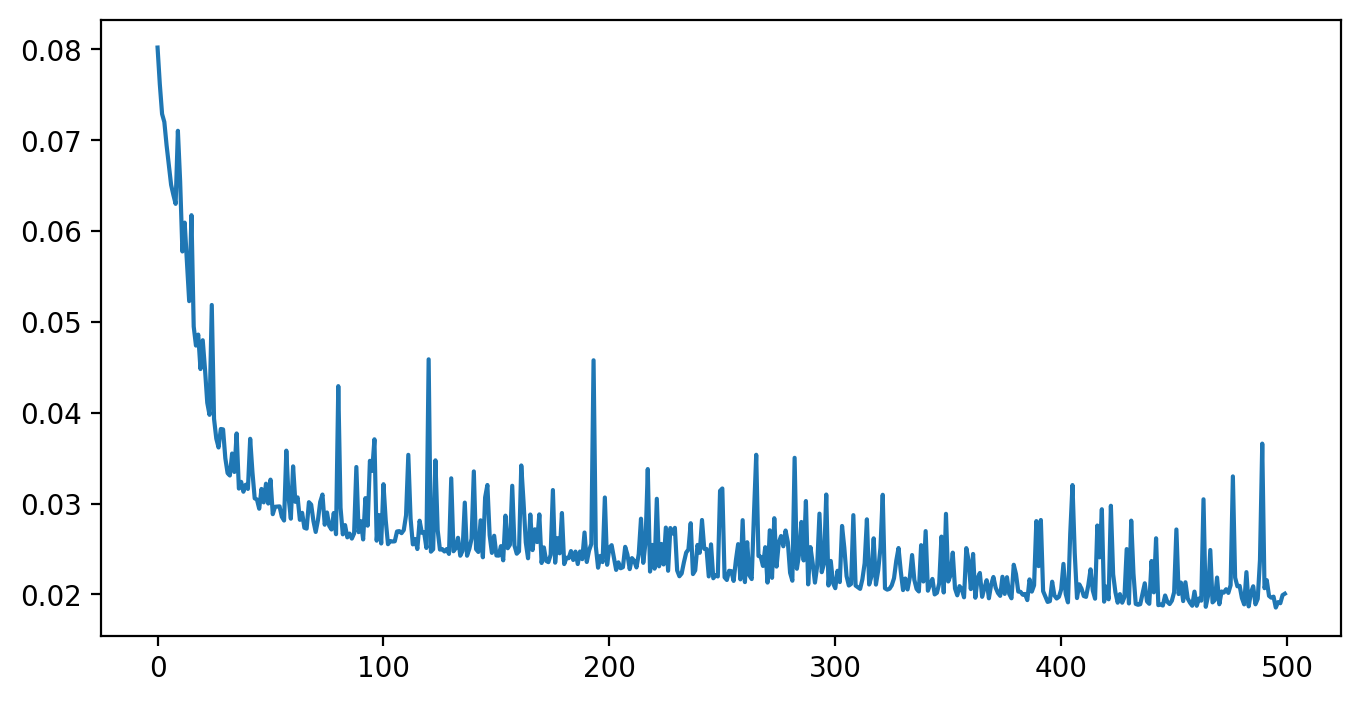

Python: [<matplotlib.lines.Line2D object at 0x37b526e90>]

In [190]:
fig,ax = subplots(1, figsize = (8, 4), dpi = 200)

ax.plot(test_losses)

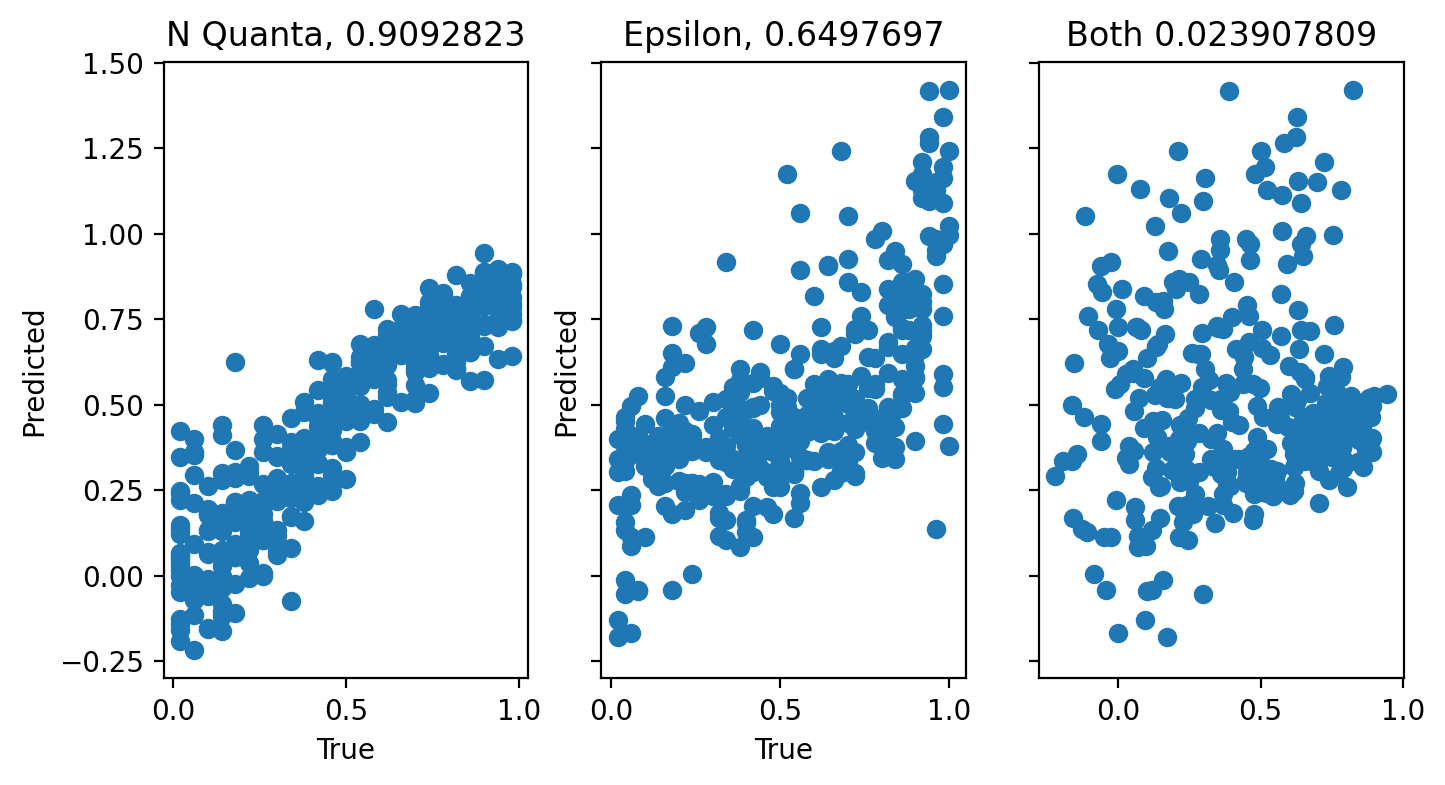

In [211]:
n_trials = 20

X_test_sampled = generate_binomial_samples(X_test, n_trials)

model_preds = model(X_test_sampled)
fig, ax = subplots(1, 3, figsize = (8, 4), dpi = 200, sharey = true)
ax[0].plot(Y_test[1, :], model_preds[1, :], "o")
q_corr = cor(Y_test[1, :], model_preds[1, :])
ax[1].plot(Y_test[2, :], model_preds[2, :], "o")
eps_corr = cor(Y_test[2, :], model_preds[2, :])

ax[2].plot(model_preds[1, :], model_preds[2, :], "o")
pred_corr = cor(model_preds[1, :], model_preds[2, :])

ax[0].set_title("N Quanta, $(q_corr)")
ax[1].set_title("Epsilon, $(eps_corr)")
ax[2].set_title("Both $(pred_corr)")

for ax_idx = 0:1
    ax[ax_idx].set_xlabel("True")
    ax[ax_idx].set_ylabel("Predicted")
end



In [192]:
X_test

301×375 view(::Matrix{Float32}, :, [1151, 312, 197, 779, 954, 284, 355, 1169, 1222, 80  …  36, 234, 347, 413, 1028, 791, 781, 71, 158, 1190]) with eltype Float32:
 0.577145  0.987636  0.995109  0.86279   …  0.983078  0.952992  0.993493
 0.56198   0.962804  0.984946  0.791347     0.960514  0.894932  0.982661
 0.538243  0.924114  0.970068  0.728056     0.934567  0.832568  0.9565
 0.536265  0.893533  0.952343  0.693704     0.916583  0.781295  0.944563
 0.528682  0.86426   0.936455  0.666694     0.892863  0.750768  0.91439
 0.516814  0.809934  0.893944  0.618834  …  0.841709  0.707178  0.867592
 0.516814  0.775431  0.86076   0.599252     0.81508   0.659151  0.830365
 0.577145  0.987262  0.995756  0.864785     0.986957  0.954177  0.9935
 0.56198   0.962272  0.988148  0.78953      0.963824  0.889107  0.982647
 0.538243  0.924864  0.975468  0.726956     0.938229  0.824743  0.95655
 0.536265  0.890314  0.962231  0.688787  …  0.918769  0.773117  0.944196
 0.528682  0.864843  0.945626  0.657488 

In [108]:
model(X)

2×1250 Matrix{Float32}:
 0.473624  0.473624  0.473624  0.473624  …  0.473624  0.473624  0.473624
 0.507819  0.507819  0.507819  0.507819     0.507819  0.507819  0.507819

In [197]:
function generate_binomial_samples(X_test, N_flips)
    # Get dimensions of X_test
    rows, cols = size(X_test)
    
    # Create output matrix
    samples = zeros(Int, rows, cols)
    
    # Generate binomial samples for each element
    for i in 1:rows
        for j in 1:cols
            p = X_test[i,j]
            samples[i,j] = rand(Binomial(N_flips, p))
        end
    end
    
    return samples ./ N_flips
end

using Distributions
N_trials = 50
generate_binomial_samples(X_test, 50)


301×375 Matrix{Float64}:
 0.36  1.0   1.0   0.9   0.84  0.98  …  0.86  1.0   1.0   1.0   0.9   1.0
 0.58  0.9   0.96  0.78  0.82  0.9      0.76  0.98  0.9   0.96  0.88  1.0
 0.6   0.92  0.96  0.74  0.72  0.9      0.74  0.96  0.84  0.96  0.82  0.98
 0.44  0.88  0.98  0.56  0.66  0.82     0.7   0.96  0.74  0.94  0.84  0.92
 0.54  0.92  0.94  0.68  0.68  0.82     0.62  0.96  0.72  0.96  0.74  0.92
 0.5   0.76  0.88  0.68  0.7   0.82  …  0.58  0.88  0.64  0.88  0.72  0.82
 0.58  0.7   0.86  0.6   0.64  0.58     0.64  0.76  0.7   0.76  0.7   0.8
 0.56  0.98  0.98  0.78  0.9   0.94     0.78  1.0   0.92  0.94  0.94  0.98
 0.52  0.96  1.0   0.72  0.74  0.9      0.66  0.98  0.86  0.96  0.9   0.98
 0.54  0.9   1.0   0.66  0.76  0.88     0.72  0.98  0.78  0.9   0.72  0.94
 0.54  0.94  1.0   0.66  0.6   0.9   …  0.62  1.0   0.76  0.88  0.82  0.94
 0.66  0.84  0.96  0.64  0.52  0.86     0.68  0.92  0.76  0.86  0.74  0.9
 0.5   0.82  0.9   0.58  0.56  0.52     0.72  0.86  0.58  0.78  0.7   0.84
 ⋮  